# Eigene Sentiment Analysis mit Python

Informationen:
<h5>Dies ist die Ausarbeitung von <u>Nico Mirchandani</u> für das Modul Deep Learning</h5>
Verlinkungen sind blau mit Unterstreichungen. Beispielsweise hier: <a href="https://www.python.org/>Ein Link zur Python Website</a>, die Programmiersprache, die ich hier verwenden werde.<br />
Dinge die ich in Studien gefunden habe, werde ich normal zitieren.
<br />
<br />


Dies ist mein (<i>Nico Mirchandani</i>) Versuch ein Deep Learning Model von Beginn an selbst zu schreiben. 
Was benötigt wird: 
<ol>
    <li>Preprocessing</li>
    <li>Lernmodell, welches am Ende eine Prediction machen kann, wie positiv/negativ/neutral ein Wort ist. Dies sollte ein Wert zwischen -1 und 1 werden</li>
    <li>Speicherung der vom Model gelernten Dinge, um nicht jedes mal von vorne das Training zu beginnen</li>
</ol>
Am Ende wird das Modell mit anderen Modellen verglichen: Modell welches importiert wird <s>& das Modell, welches von <u>Duc Anh Pham</u> verbessert wurde</s>

Bevor ich mit diesem Projekt angefangen habe, hab ich ein paar Tutorials bearbeitet. Was mir aufgefallen ist, ist das viele Leute irgendwelche Libaries nutzen, die die Ganze Arbeit übernehmen. Darunter auch pretrained-Models. <br />
Eine Libary wurde häufig genutzt und ist sehr simple: Textblob. Dies hab ich in einem Youtube Video von <a href="https://www.youtube.com/watch?v=tXuvh5_Xyrw">NeuralNine</a> gesehen.

In [1]:
from textblob import TextBlob #Textblob muss natürlich vorher runtergeladen werden. 

text = "I love it"

blob = TextBlob(text)
sentimentTextBlobPositive = blob.sentiment.polarity 
#Ich speicher das hier in einer Variable, um das unten mit meinen Ergebnissen zu vergleichen

text = "I hate it"

blob = TextBlob(text)
sentimentTextBlobNegative = blob.sentiment.polarity
#Ich speicher das hier in einer Variable, um das unten mit meinen Ergebnissen zu vergleichen

print(sentimentTextBlobPositive)
print(sentimentTextBlobNegative)

0.5
-0.8


Für das Ganze werden vor die Keywords ("hate", "love")stärker verwendet und sogenannte Stopwords("I", "It") weniger:

In [2]:
text = "love"

blob = TextBlob(text)
sentimentTextBlobKeyLove = blob.sentiment.polarity 
#Ich speicher das hier in einer Variable, um das unten mit meinen Ergebnissen zu vergleichen
text = "hate"

blob = TextBlob(text)
sentimentTextBlobKeyHate = blob.sentiment.polarity 

text = "I it"

blob = TextBlob(text)
sentimentTextBlobStop = blob.sentiment.polarity
#Ich speicher das hier in einer Variable, um das unten mit meinen Ergebnissen zu vergleichen

print(sentimentTextBlobKeyLove)
print(sentimentTextBlobKeyHate)
print(sentimentTextBlobStop)

0.5
-0.8
0.0


Ich könnte später einfach ein Stopword Datensatz importieren, doch wie man später sehen wird, hab ich das anders gelöst. Wörter die häufig vorkommen werden bei mir eine niedrigere Gewichtung haben, als Wörter die häufig vorkommen. Aber dazu später mehr.

Jetzt wo man weiß, wohin es gehen soll, werde ich darauf hinarbeiten. <br />
Als erstes importiere ich ein paar Libaries. Die Anzahl dieser soll möglichst gering bleibe.

In [3]:
import csv # Für csv Dateien, damit ich mein Model trainieren kann
from collections import Counter
import numpy as np
import json # Für json datei(meine Abspeicherungen)
from matplotlib import pyplot as plt
import time

Zudem definiere ich mir ein paar Farben für die prints. Direkt danach ein Template für Fehlermeldungen<br />
Gefunden auf <a href="https://stackoverflow.com/questions/287871/how-do-i-print-colored-text-to-the-terminal">StackOverflow</a>

In [4]:
CRED = "\033[91m"
CORANGE = "\033[33m"

error = CRED +"[Error]: " + CORANGE

Felder/Arrays in Variablen zu speichern, die ich später generell nutzen kann ist auch ganz gut, um das immer erweitern zu können
<ol>
    <li>Satzzeichen</li>
    <li>Negationen</li>
    <li>Symbole etc.</li>
</ol>

In [5]:
#1
stop = [",", "!", ".", "?", ":", "&"]
#2
negation = ["not", "isn't", "isnt", "doesn't", "doesnt", "dont", "don't", "wont", "won't", "werent", "weren't", "shouldnt",
           "shouldn't", "didnt", "didn't", "arent", "aren't", "havent", "haven't", "hadnt", "hadn't", "can't", "cannot", 
            "aint", "ain't"]
for x in negation:
    if "'" in x:
        arr = x.split("'")
        negation.append(arr[0])
        negation.append(arr[0] + "´" + arr[1])
        negation.append(arr[0] + "`" + arr[1])

#3
signs = ["\\", "\"", "/", "(", ")", "{", "}", "<", ">", "~", "'", "[*]", "[b]", "[u]", "+", "*", ";", "-", "`", "´", "_",
         "#", "\\t", "\\b", "\t", "\b", "%", "$", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "=", "^", "[", "]", 
         "\u0010own", "\u000b\u000b", "\u000b", "\u000b\u000b", "\u000b\u000b", "\u000b", "\u0002", "\u0003", "\u0004", 
         "\u0005", "\u0010", "\u0013", "\u0014", "\u0015", "\u0016", "\u0018", "\u0019"]

Nun ein paar erste Funktionen, die ich später fürs Preprocessing nutzen kann. 
<ol>
    <li>Funktion, die in einem String bestimmte Buchstabensequenzen sucht und den selben String returnen, jedoch ohne Wörter mit den Buchstabensequenzen</li>
    <li>Funktion, die in Arrays nach Values schaut, die nichts enthalten, und einen array returned ohne diese Values</li>
</ol>

In [6]:
#1
def deleteWordbySearch(sentence, search):
    arr = sentence.split(" ")
    result = ""
    for x in arr:
        if search not in x:
            result += x + " "
    return result[:-1]

#2
def deleteWhitespacesinArray(arr = []):
    result = []
    for x in arr:
        if x != "":
            result.append(x)
    return result

Eine Idee, was ins Preprocessing gehört habe ich aus folgenden Quellen: <br />
[Apoorv Agarwal, Boyi Xie, Ilia Vovsha, Owen Rambow, and Rebecca Passonneau. 2011. <b>Sentiment Analysis</b> of Twitter Data. In Proceedings of the Workshop on Language in Social Media (LSM 2011), pages 30–38, Portland, Oregon. Association for Computational Linguistics.]<br />
[Gupta, Bhumika & Negi, Monika & Vishwakarma, Kanika & Rawat, Goldi & Badhani, Priyanka. (2017). <b>Study of Twitter Sentiment Analysis using Machine Learning Algorithms on Python</b>. International Journal of Computer Applications. 165. 29-34. 10.5120/ijca2017914022.] <br />
<a href="https://www.analyticsvidhya.com/blog/2021/08/text-preprocessing-techniques-for-performing-sentiment-analysis/">Text Preprocessing techniques for Performing Sentiment Analysis!</a>
<br /><br />
Andere Dinge sind mir nach testen des Systems an einem Datasets aufgefallen <br /> 
Dies kann das Preprocessing bereits:
<ol>
    <li>
        Bestimmte Wörter werden gelöscht
        <ul>
            <li>URLs</li>
            <li>Email-Adressen</li>
        </ul>
    </li>
    <li>Eine Satzaufteilung</li>
    <li>Negationen kennzeichnen</li>
    <li>Wörter aufteilen</li>
    <li>Löschen von verschiedenen Zeichen und Tags</li>
</ol>

In [7]:
#1
def pre_deleteWords(string):
    string = deleteWordbySearch(string, "@")
    string = deleteWordbySearch(string, "http")
    
    return string

#2
def pre_sentence_split(string):
    
    result = []
    
    st = string
    i = 0
    hasStop = 0
    while i < len(st):
        if st[i] in stop:
            hasStop = 1
            thestop = st[i]
            s = st.split(thestop, 1) # string.split(a, 1) 1 deutet an wie häufig gesplittet wird
            result.append(s[0])
            result.append(thestop)
            n=1
            st = ""
            while n < len(s):
                st += s[n]
                n+=1
                
            i=0
        else:
            i+=1
    result.append(st)
    
    return result
#3
def pre_negation(arr):
    result = []
    for x in arr:
        b = 0
        words = x.split(" ")
        for word in words:
            if word in negation:
                b = 1
        if b == 1:
            result.append(0)
        else:
            result.append(1)
        
    return result

#4
def pre_tokenizer(string):
    result = []
    
    arr = string.split(" ")
    
    for word in arr:
        result.append(word)
    
    return result
#5
def deleteSpecialTags(string):
    
    string = string.encode("ascii", "ignore")
    string = string.decode()
    string = string.replace("\n", ".")
    
    for x in signs:
        string = string.replace(x, " ")
    
    return string

Nun eine Funktion, die alle Preprocessing Funktionen vereint. Das Ganze hätte man auch in eine Große Funktion hineinschreiben können, jedoch soll dies der Übersicht dienen.

In [8]:
def preprocessing(string):
    string = pre_deleteWords(string)
    string = string.lower()
    string = deleteSpecialTags(string)
    
    arr = pre_sentence_split(string)
    
    negations = pre_negation(arr)
    
    result = []
    
    i = 0
    for x in arr:
        x = deleteWhitespacesinArray(pre_tokenizer(x))
        result.append(x)
    
    return result, negations
print(preprocessing("i am happy, i am not happy"))

([['i', 'am', 'happy'], [','], ['i', 'am', 'not', 'happy']], [1, 1, 0])


Nach angewendeten Preprocessing soll das Ganze wie folgt aussehen:<br />
<b>(</b>[<i>[Satz 1]</i>, <i>[Satzzeichen]</i>, <i>[Satz 2]</i>, <i>[Satzzeichen]</i>, <i>[Satz 3]</i>], [<i>Negation 1</i>, <i>Negation 2</i>, <i>Negation 3</i>, <i>Negation 4</i>, <i>Negation 5</i>]<b>)</b><br /><br />
Jetzt braucht man ein Modell, welches Wörter mit einem Sentiment Wert verbindet. Hierzu erstelle ich die Klasse NeuronalNetwork. Der Zustand ist ein Wert zwischen -1 und 1. Hier nenne ich ihn Sentiment.<br />
Diese beinhaltet die Methoden:
<ol>
    <li><b>__<u>init</u>__</b><br/>
Zur Erstellung von diesem Objekt</li>
    <li><b><u>setNeuron</u></b><br/>
Setzt ein Wort mit einem Zustand zwischen -1 und 1 in Verbindung. Wörter können mit mehr als nur einen Zustand in Verbindung gebracht werden.</li>
    <li><b><u>trainModel</u></b><br />
Bekommt Sätze mittels eines Strings und einen Zustand. Diese Sätze werden durchs Preprocessing verarbeitet. Am Ende gibt es nur noch einzelne Wörter und Satzzeichen, siehe Preprocessing. Danach wird die Funktion setNeuron genutzt, um Wörtern einen neuen Zustand zu geben. Hier wird auch auf Negationen geachtet. 
    <li><b><u>getNeuron</u></b><br />
Wird mithilfe eines Wortes aufgerufen. Es wird zurückgegeben ein Tupel aus dem Durchschnitt aller Werte und den Werten.</li>
    <li><b><u>getRating</u></b><br />
Hier wird ein Rating für Sätze ausgebildet. Es wird drauf geachtet, dass Wörter mit höheren/niedrigeren Werten mehr Gewicht haben, als eher niedrige. So sollen beispielsweise neutralere Wörter, wie "I", "and" etc weniger Bedeutung haben als "hate" </li>
    <li><b><u>saveNeurons</u></b><br />
Speichert die Wörter und Zustände in einer Datei
    <li><b><u>getNeuronsfromJson</u></b><br />
Holt die Wörter und Zustände aus einer JSON Datei</li>
    <li><b><u>getHowManyWords</u></b><br />
Gibt zurück wie viele Wörter schon gespeichert wurden
</ol>

In [9]:
class NeuronalNetwork():
    neurons = {}
    lenall = 0
    name = ""
    lenwords = 0
    #1
    def __init__(self, name:str):
        self.words = {}
        self.lenall = 0
        self.name = name
        self.lenwords = 0
        #self.getNeuronsfromJson()
    #2    
    def setNeuron(self, word:str, sentiment:float):
        if sentiment >= -1 and sentiment <= 1 and len(word.split(" ")) == 1:
            if len(word) > 0:
                if word[0] in self.neurons:
                    if word in self.neurons[word[0]]:
                        if sentiment in self.neurons[word[0]][word]:
                            self.neurons[word[0]][word][sentiment] += 1
                        else:
                            self.neurons[word[0]][word][sentiment] = 1
                            self.lenwords +=1
                    else:
                        self.neurons[word[0]][word] = {}
                        self.neurons[word[0]][word][sentiment] = 1
                        self.lenwords +=1
                else:
                    self.neurons[word[0]] = {}
                    self.neurons[word[0]][word] = {}
                    self.neurons[word[0]][word][sentiment] = 1
                    self.lenwords +=1
            
        else:
            print(error + "Sentiment must be below or equal 1 and above or equal -1 \n" +CRED +"Error: " + CORANGE +"Error: It can only be one word.")
    #3    
    def trainModel(self, string, sentiment):
        arr = preprocessing(string)
        #print(string)
        #print(sentiment)
        i = 0
        self.lenall+=1
        for x in arr[0]:
            s = sentiment
            result = x
            if arr[1][i] == 0:
                result = []
                s = s * (-1)
                for word in x:
                    if len(word) > 0:
                        if word not in negation:
                            result.append(word)
            for word in result:
                self.setNeuron(word, s)
            i+=1
    #4
    def getNeuron(self, word:str):
        if word[0] in self.neurons:
            if word in self.neurons[word[0]]:
                result = 0
                i = 0
                for x in self.neurons[word[0]][word].keys():
                    b = int(x)
                    a = int(self.neurons[word[0]][word][b])
                    result += x*a
                    #print(a)
                    i += int(a)
                return result/i, i
            else:
                return 0, 0
        else:
            return 0, 0
    #5
    def getRating(self, string):
        arr = preprocessing(string)
        i = 0
        sentiment = 0
        a = 0
        for x in arr[0]:
            #print(x)
            negation = 1
            if arr[1][i] == 0:
                negation = -1
            for word in x:
                a += 1
                c = 0.5
                d = self.getNeuron(word)[1]
                if d/self.lenall >= c:
                    sentiment += 0.5 * self.getNeuron(word)[0] * negation
                    a += 0.5
                while c > 0.001: #Je weniger ein Wort vorkommt, desto mehr Wert legt man auf dieses Wort
                    if d/self.lenall < c:
                        sentiment+=self.getNeuron(word)[0] * negation
                        a+=1
                    else:
                        break
                    c/=2
            i+=1
        if a == 0:
            return 0
        else:
            return sentiment / a
    #6
    def saveNeurons(self):
        jsonString = self.neurons
        config = {}
        jsonString["lenall"] = self.lenall
        jsonString["lenwords"] = self.lenwords
        json.dump(jsonString,open(self.name+'.json','w'),indent=4,sort_keys=True)
    #7    
    def getNeuronsfromJson(self):
        f = open(self.name+'.json')
        self.neurons = json.load(f)
        self.lenall = self.neurons["lenall"]
        self.lenwords = self.neurons["lenwords"]
        print(self.neurons)
        #print(self.neurons)
    #8
    def getHowManyWords(self):
        return self.lenwords
    

Hier mache ich eine Funktion, die fürs Training wichtig ist. So haben die beiden Datensätze entweder ein Rating von 1-5 oder ein Sentiment von "positive", "negative" oder "neutral". Diese müssen einen passenden Zustandswert bekommen, der zwischen -1 und +1 liegt.

In [10]:
def rating(i:float) -> float:
    result = 0
    if(i == 5):
        result = 1
    elif(i == 4):
        result = 0.5
    elif(i == 3):
        result = 0
    elif(i == 2):
        result = -0.5
    elif(i == 1):
        result = -1
    elif(str(i).lower() == "positive"):
        result = 1
    elif(str(i).lower() == "neutral"):
        result = 0
    elif(str(i).lower() == "negative"):
        result = -1
    elif(str(i).lower() == "true"):
        result = 1
    elif(str(i).lower() == "false"):
        result = -1
    
    return result

Evaluationsansätze: <br />
<a href="https://www.jeremyjordan.me/evaluating-a-machine-learning-model/">Evaluating a machine learning model</a>
- Datensätze nehmen: einer eher negativ, einer neutral,  einer eher positiv
    - Jeweils mit einem anderen Datensatz dann auswerten, wie viele macht er richtig, wie schneidet er im Vergleich <s>zu Ducs und</s> zu einem anderen ab?
    Kurzes Bild wie das aussehen kann:
    <img src="https://www.jeremyjordan.me/content/images/2017/07/Screen-Shot-2017-07-21-at-9.57.38-AM.png" width=500px height= 500px>
- Lernkurve, alle 50k Datensätze wird aus einem Datensatz was ausgewertet, wann bekommt man brauchbare Ergebnisse? Wie sieht es im Vergleich zu anderen Modellen aus?
- Um das schön auswerten zu können, braucht es Werte, die man miteinander automatisch vergleichen kann. Diese kann man wie folgt ausrechnen (Quelle ist oben verlinkt)

"<b>Accuracy</b> is defined as the percentage of correct predictions for the test data. It can be calculated easily by dividing the number of correct predictions by the number of total predictions." (<a href="https://www.jeremyjordan.me/evaluating-a-machine-learning-model/">Quelle 23.11.2022</a>)<br />
$ accuracy = \frac{correct predictions}{all predictions} $<br /><br />
"<b>Precision</b> is defined as the fraction of relevant examples (true positives) among all of the examples which were predicted to belong in a certain class. "(<a href="https://www.jeremyjordan.me/evaluating-a-machine-learning-model/">Quelle 23.11.2022</a>) <br />
$ precision = \frac{true positives}{true positives + false positives} $ <br /><br />
<br />
"<b>Recall</b> is defined as the fraction of examples which were predicted to belong to a class with respect to all of the examples that truly belong in the class."(<a href="https://www.jeremyjordan.me/evaluating-a-machine-learning-model/">Quelle 23.11.2022</a>) <br />
$ recall = \frac{true positives}{true positives + false negatives} $ <br /><br />

Auf der Website wird beschrieben, wie man einen Wert ausrechnen kann die man als Endnote bezeichnen kann.

$ F_\beta = (1+ \beta^2) \frac{precision * recall}{(\beta^2*precision)+recall} $

Deshalb eine Methode, die aus den angegebenen Zahlen accuracy, precision, recall und den $ F_\beta $ Wert ausgibt

In [11]:
def evaluate(truepositive, truenegative, falsepositive, falsenegative, beta=1):
    accuracy = (truenegative + truepositive)/(truenegative + truepositive + falsenegative + falsepositive)
    
    precision = truepositive/(truepositive+falsepositive)
    
    recall = truepositive/(truepositive+falsenegative)

    f = (1+beta**2) * (((precision*beta**2)*recall)/(precision+recall))
    
    return f, accuracy, precision, recall

In [12]:
def testing(nn, zeilen=10000):
    with open('test.csv', encoding='utf-8') as csvdatei:
        csv_reader_object = csv.reader(csvdatei)
        zeile = 1;
        truepositive = 0
        truenegative = 0
        falsepositive = 0
        falsenegative = 0

        for row in csv_reader_object:
            if zeile < zeilen:
                rate = 0
                if int(row[0]) == 2:
                    rate = 1
                elif int(row[0]) == 1:
                    rate = -1
                rating = nn.getRating(row[1] + row[2])
                if rating < 0:
                    rating = -1
                else:
                    rating = 1
                if rate == rating:
                    if rate == 1:
                        truepositive+=1
                    elif rate == -1:
                        truenegative += 1
                else: 
                    if rate == 1:
                        falsepositive+=1
                    elif rate == -1:
                        falsenegative += 1
                zeile +=1
        return evaluate(truepositive, truenegative, falsepositive, falsenegative), truepositive, truenegative, falsepositive, falsenegative

Beta wird bei der Bewertung 1 sein, damit eine gleiche Gewichtung herrscht

Zeit rauskopiert aus <a href="https://gertingold.github.io/pythonnawi/profiling.html">Laufzeituntersuchungen</a>


In [13]:
nn = NeuronalNetwork("6")

learningcurve = []
start = time.time()
with open('train.csv', encoding='utf-8') as csvdatei:
    csv_reader_object = csv.reader(csvdatei)
    zeile = 0;
    gespeichert = 0
    for row in csv_reader_object:
        if zeile > 1:
            rate = 0
            if int(row[0]) == 2:
                rate = 1
            elif int(row[0]) == 1:
                rate = -1
            #print(rate)
            nn.trainModel(row[1], rate)
            nn.trainModel(row[2], rate)
        zeile +=1
        if zeile % 50000 == 0 and zeile != 0:
            print("Zeile: " + str(zeile))
            learning = testing(nn)
            print(learning)
            learningcurve.append(learning)
            nn.saveNeurons()
    print(zeile)
ende = time.time()
timetrainwithcurve = '{:5.3f}s'.format(ende-start)

Zeile: 50000
((0.7939066513152068, 0.7672767276727672, 0.8747072599531616, 0.7267715258634668), 4482, 3190, 642, 1685)
Zeile: 100000
((0.8031757110451928, 0.7743774377437744, 0.8983216237314599, 0.7262543389081729), 4603, 3140, 521, 1735)
Zeile: 150000
((0.8099467140319715, 0.785978597859786, 0.8899297423887588, 0.7431551499348109), 4560, 3299, 564, 1576)
Zeile: 200000
((0.8122769450392576, 0.7895789578957896, 0.8883684621389539, 0.7481919789612097), 4552, 3343, 572, 1532)
Zeile: 250000
((0.8070949523473351, 0.7813781378137814, 0.8924668227946917, 0.7366301546391752), 4573, 3240, 551, 1635)
Zeile: 300000
((0.8069276309976142, 0.7814781478147815, 0.8911007025761124, 0.7372840303568545), 4566, 3248, 558, 1627)
Zeile: 350000
((0.8065342163355408, 0.7808780878087809, 0.8912958626073381, 0.7364941138526044), 4567, 3241, 557, 1634)
Zeile: 400000
((0.80984538830638, 0.785978597859786, 0.889344262295082, 0.7433931484502447), 4557, 3302, 567, 1573)
Zeile: 450000
((0.8107149192833065, 0.78657865

((0.8189921454417086, 0.7948794879487949, 0.9055425448868072, 0.7475430965039471), 4640, 3308, 484, 1567)
Zeile: 3500000
((0.8189282245960978, 0.7948794879487949, 0.905152224824356, 0.7477027244881509), 4638, 3310, 486, 1565)
Zeile: 3550000
((0.8187516553368059, 0.7946794679467947, 0.9049570647931303, 0.7475415121715299), 4637, 3309, 487, 1566)
Zeile: 3600000
((0.8184066419360537, 0.7943794379437944, 0.9041764246682279, 0.7474991932881575), 4633, 3310, 491, 1565)
3600000


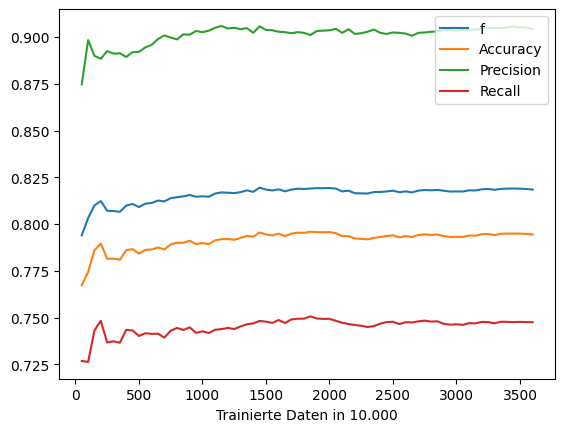

Time: 2199.915s
Accuracy: 0.7943794379437944
Precision: 0.9041764246682279
Recall: 0.7474991932881575
F: 0.8184066419360537

 Endresultat: 
Accuracy: 0.7938019845049613
Precision: 0.89315
Recall: 0.7451019650536626
F: 0.8124364679957884
True positive: 178630
True negative: 138890
False positive: 21370
False negative: 61109


In [14]:
x = []
z = 0
for y in learningcurve:
    z+=50
    x.append(z)
    
accuracy = []
recall = []
precision = []
f = []

for a in range(len(learningcurve)):
    f.append(learningcurve[a][0][0])
    accuracy.append(learningcurve[a][0][1])
    recall.append(learningcurve[a][0][3])
    precision.append(learningcurve[a][0][2])
plt.plot(x, f, label="f")
plt.plot(x, accuracy, label="Accuracy")
plt.plot(x, precision, label="Precision")
plt.plot(x, recall, label="Recall")
plt.legend(loc="best")
plt.xlabel("Trainierte Daten in 10.000")
plt.show()

print("Time: " + str(timetrainwithcurve))

print("Accuracy: " + str(learningcurve[len(learningcurve)-1][0][1]))
print("Precision: " + str(learningcurve[len(learningcurve)-1][0][2]))
print("Recall: " + str(learningcurve[len(learningcurve)-1][0][3]))
print("F: " + str(learningcurve[len(learningcurve)-1][0][0]))

learning = testing(nn, 400000)
learningcurve.append(learning)
print("\n Endresultat: ")
print("Accuracy: " + str(learningcurve[len(learningcurve)-1][0][1]))
print("Precision: " + str(learningcurve[len(learningcurve)-1][0][2]))
print("Recall: " + str(learningcurve[len(learningcurve)-1][0][3]))
print("F: " + str(learningcurve[len(learningcurve)-1][0][0]))
#truepositive, truenegative, falsepositive, falsenegative
print("True positive: " + str(learningcurve[len(learningcurve)-1][1]))
print("True negative: " + str(learningcurve[len(learningcurve)-1][2]))
print("False positive: " + str(learningcurve[len(learningcurve)-1][3]))
print("False negative: " + str(learningcurve[len(learningcurve)-1][4]))

#### Randnotiz an mich
```python
import gzip, zip
with gzip.open("meineDatei.txt.gz") as f:
```

Finale Präsentation:
- Intro, was wird gemacht
- Struktur, Subthema
- Evaluation
- Was sollte man aus Grafik mitnehmen drauf schreiben
- Fazit, Ausblick? Was  hat geklappt, was nicht
- ca. 15 bis 20 Minuten

Code Github<br />
dazu readme-Datei mit bspw. Imports

In [ ]:
print("fertig")

Time: 1745.950s

